# Model development

This notebook will provide a comprehensive guide to getting started with modelling and prediction in python!

Agenda:

- data preprocessing recap
- introduction to modeling
- examples

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import sklearn
import scipy
import statistics
import math
import tensorflow as tf

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM, GRU, TimeDistributed, Dense, Input

## The dataset

https://www.kaggle.com/code/headsortails/wiki-traffic-forecast-exploration-wtf-eda

The dataset consists of 145000 separate time series, each of which has around some days' worth of data from 2015 to 2016. Each series is measuring the web traffic flow across a wikipedia article.

## The goal

We will be creating a model to forecast the traffic on each of the machines upto several weeks in the future. We will do this using a conventional method, and using deep learning.

_NOTE: the goal of this workshop is to actually explain the process of building a model, not the theory behind it. Thus, time series analysis will only be covered briefly._

## What do we need to do?

We have preprocessed our data. Now we must choose some models to use on this data and make some predictions. Then we'll evaluate our models' performance!

## Preprocessing

In this section, we port over the preprocessing logic from `preprocessing_matplotlib.ipynb`. In that notebook, we decided we would drop all rows with `NaN` values, except those where the runs of `NaN` values are at most 2 `NaN`s long. We would fill these rows with interpolated values.

While this covers general preprocessing, we will need to do some model-specific preprocessing (and postprocessing) later on.

In [2]:
train_df = pd.read_csv("dataset/train_1.csv")

key_df = pd.read_csv("dataset/key_1.csv")

train_df.set_index("Page", inplace=True, drop=True)
key_df.set_index("Page", inplace=True, drop=True)

# dropping all rows which only contain NaN values
train_df = train_df[~pd.isnull(train_df).all(axis=1)]

# finding all rows where the runs of NaN are of length 2 at most
def find_all(x):
    nan_size = 0
    nan_find = np.isnan(x.values)
    for val in nan_find:
        if val:
            nan_size += 1
            if nan_size > 2:
                return False
        else:
            nan_size = 0
    return True

# dropping all rows which don't satisfy above condition
nan_run_df = train_df.apply(find_all, axis=1)
train_df["keep"] = nan_run_df
nan_run_df.head()

train_df = train_df[train_df["keep"]]

# interpolating values
train_df.interpolate(inplace=True)

del train_df["keep"]

## What is a model?

A model is a function that represents a dataset.

## Why do we need a model?

Datasets are simply a list of numbers. The most we can do is gain some insight into them by calculating results based on their contents, such as an average, or standard deviation. However, to actually make predictions based on the data, gain additional insight, or manipulate the data, we must represent it in a form that gives it mathematical structure.

## Parts of a model

Models have several general parts:

- dataset: the underlying data used to train the model
- parameters (also known as weights or biases): set of fields that describe the dataset
- hyperparameters: set of numbers used to configure the model or parts of the model before it is fitted to the dataset
- fitting algorithm/training loop: algorithm used to deduce the values of the parameters for the model
- prediction function: function that uses the parameters to predict values for inputs to the model
- input space: set of eligible inputs for the prediction function
- ouput space: set of eligible outputs for the prediction function

These parts are very abstract, and will vary quite drastically from model to model.

## An example

Say you have the following data for the result of 10 coin flips of a regular 2-sided coin (heads and tails are equally likely):

HHTHTTHTTT

We could represent this data using a binomial distribution. Recall the definition of a binomial distribution:

$$ X \sim Binom(n, \theta) \rightarrow P(X = x) = \binom{n}{x}\theta^{x}(1-\theta)^{n-x} $$

We have 1 hyperparameter $n$: the size of our dataset. In this case, $n = 10$.

What about $\theta$? Intuition tells us to set $\theta = 0.5$, however we cannot naively do that. Our goal is to fit this binomial distribution to the data we have, not to the general case. So how do we find the best value of $\theta$?

This must be done using a maximum likelihood estimate, which finds the optimal value of $\theta$ such that the resulting model makes our observed data the most likely case.

- determine the likelihood function $L(\theta)$.
- determine the log-likelihood function $l(\theta)$.
- determine $\frac{dl}{d\theta}$.
- find $\theta$ such that $l(\theta)$ is maximized.

This is our fitting algorithm. Once these steps are followed, the optimal value of $\theta = 0.4$ is found. We can now say that $X \sim Binom(10, 0.4)$ is our model for the data. $P(X = x)$ is our prediction function- we can now input values of $x$ and see the probability we observe that many heads (WLOG) given the baseline established by our dataset.

Recap:

- dataset: set of 10 observed coin flips (HHTHTTHTTT)
- parameters: $\theta$
- hyperparameters: $n$
- fitting algorithm: procedure for finding maximum likelihood estimate
- prediction function: $P(X = x; \theta)$
- input space: numbers from 0 to 10
- output space: a number from 0 to 1

## Fitting a model

The models we use in practice are of course miles more complex than a simple binomial distribution. They often have thousands or millions of parameters, and these all need to be optimized. We could do this one-by-one but that's infeasible. Instead, algorithms have been developed to determine the parameters iteratively using numerical methods.

Machine learning is, simply put, the application of the fitting algorithm. Through successive iterations, the computer (or machine) "learns" the dataset- updating its parameters to better represent the dataset.

## Overfitting and underfitting

The fitting algorithm may require some hyperparameters to control how the model is fit to the data. These hyperparamters will affect the results of the training, and therefore need to be set correctly (or reasonably well) to ensure good results.

If the model is fitted using incorrect paramters, we may end up with 1 of 2 scenarios:

### Underfitting

Underfitting occurs when the fitted model does not capture enough features of the data. This can result in bad predictions on many different inputs, but most notably, terrible performance on outliers and more extreme inputs. Graphically, underfitting may look something like this:

![alt text](assets/underfitting.png "Title")

### Overfitting

Overfitting occurs when the fitted model captures too many features of the data. Specifically, this means it becomes very good at recognizing outliers, but very bad at classifying ordinary inputs. This can result in bad predictions on many different inputs, but most notably, terrible performance on ordinary inputs. Graphically, overfitting may look something like this:

![alt text](assets/overfitting.png "Title")

### Good fitting

A good fit for the above data looks like this:

![alt text](assets/goodfitting.png "Title")

The reason this is a good fit is because the line seems to cover all the points without making any weird compromises to reach any one point. Furthermore, it gives us actual insight into the trend of the data.

## Configuring a model

Configuring a model may need a substantial amount of trial and error. This will often eman tweaking the hyperparamters in order to ensure optimal performance on the dataset. There are many ways to measure the performance of your model which may prove useful in the configuration stage. While you may start with random values for your hyperparameters, you could use the values of these metrics on different hyperparameters to guide yourself.

There are better techniques for choosing hyperparameters than trial and error, however it's best to reason through it when you're starting out!

## Evaluating performance

When training and testing a model, we rely on our dataset as both a basis for training and a benchmark for testing. To ensure that our testing results are not scuffed, we divide our data into a train/test split. A train/test split will split the data into a (mutually exclusive) training set and a testing set (sometimes we also add a validation split). The training set is used to train the model, and the test set provides a benchmark on data the model has never seen before. These may result in different values for your performance metrics, which can help quite a bit in choosing hyperparamters!

## Choosing models for our dataset

Many models are built to perform a specific tasks or to operate on a specific type of data. In this case, our task is time series forecasting. We chose 3 different models to use for this task:

- Decision Tree Regression
- SARIMA (Seasonal Autoregressive Integrated Moving Average)
- RNN (Recurrent Neural Network)

These may or may not be the best models for the job. What matters is how we configure, train, and test them!

## Model 1: Decision Tree Regression

Decision tree regression is a method for regression which employs decision trees to learn local regressions instead of relying on a single, gloabl regression. Each input is fed through a decision tree, eventually reaching a leaf which is then updated to reflect the average of the values that ended up there. By updating over multiple iterations, the decision tree is tuned so that it can predict for unknown points later on.

Quick facts:

- dataset: one single time series
- parameters: decision tree
- hyperparameters: random state (for initialization)
- fitting algorithm: multiple iterations to create/tune the decision tree
- prediction function: run an unknown point through the decision tree to get a predicted value
- input space: time series sequence of a specified length
- output space: real numbers

### Preprocessing

The decision tree creation relies on a couple of values from our input time series to act as a "hint" to predict the output on. These values are picked in sequence, and are known as lags of the time series. We construct our lags as follows:

To predict the value at $t_n$, we use the values $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$ for some value $k$ as our lags for prediction.

We will need to construct lags to enable training. Thus, for each point in the time series from the $k$th point onward, we construct a dataframe of $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$. The lag values are stored in the columns $[X_1, X_2, ..., X_k]$. The output value is stored in column $y$.

_Sidenote: Is $k$ a hyperparamter?_ The answer varies based on how you define hyperparamter. Since $k$ is unknown to the model, it is not technically a hyperparameter, though we use it to configure our data for training.

In [5]:
# creates our dataframe of lags
def create_train_test_dtr(row, n_steps=6):
    ret_df = pd.DataFrame(columns=([f"X_{i}" for i in range(1, n_steps + 1)] + ["y"]))
    for i in range(0, n_steps):
        ret_df[f"X_{i + 1}"] = row.shift(-i)
    ret_df["y"] = row.shift(-n_steps)
    return ret_df

# creates our train/test split
def train_test_split_dtr(X, y, train_fraction=0.8):
    return X.iloc[:int(train_fraction*len(X))], \
            X.iloc[int(train_fraction*len(X)):], \
            y.iloc[:int(train_fraction*len(y))], \
            y.iloc[int(train_fraction*len(y)):]

train_test_df = create_train_test_dtr(train_df.iloc[0]).dropna()

X = train_test_df[[f"X_{i}" for i in range(1, 7)]]
y = train_test_df["y"]

X_train, X_test, y_train, y_test = train_test_split_dtr(X, y)

print(X_train)

print(y_train)

             X_1   X_2   X_3   X_4   X_5   X_6
2015-07-01  18.0  11.0   5.0  13.0  14.0   9.0
2015-07-02  11.0   5.0  13.0  14.0   9.0   9.0
2015-07-03   5.0  13.0  14.0   9.0   9.0  22.0
2015-07-04  13.0  14.0   9.0   9.0  22.0  26.0
2015-07-05  14.0   9.0   9.0  22.0  26.0  24.0
...          ...   ...   ...   ...   ...   ...
2016-09-03  25.0  19.0  23.0  18.0  19.0  18.0
2016-09-04  19.0  23.0  18.0  19.0  18.0  55.0
2016-09-05  23.0  18.0  19.0  18.0  55.0  16.0
2016-09-06  18.0  19.0  18.0  55.0  16.0  65.0
2016-09-07  19.0  18.0  55.0  16.0  65.0  11.0

[435 rows x 6 columns]
2015-07-01     9.0
2015-07-02    22.0
2015-07-03    26.0
2015-07-04    24.0
2015-07-05    19.0
              ... 
2016-09-03    55.0
2016-09-04    16.0
2016-09-05    65.0
2016-09-06    11.0
2016-09-07    11.0
Name: y, Length: 435, dtype: float64


In [6]:
X_train = X_train.sort_index()
X_test = X_test.sort_index()
y_train = y_train.sort_index()
y_test = y_test.sort_index()

# model creation and training
dt_reg = DecisionTreeRegressor(random_state=42)

dt_reg.fit(X_train, y_train)

# model prediction
dt_reg_pred = dt_reg.predict(X_test)

[Text(0.0, 0, '2016-09-08'),
 Text(20.0, 0, '2016-09-28'),
 Text(40.0, 0, '2016-10-18'),
 Text(60.0, 0, '2016-11-07'),
 Text(80.0, 0, '2016-11-27'),
 Text(100.0, 0, '2016-12-17')]

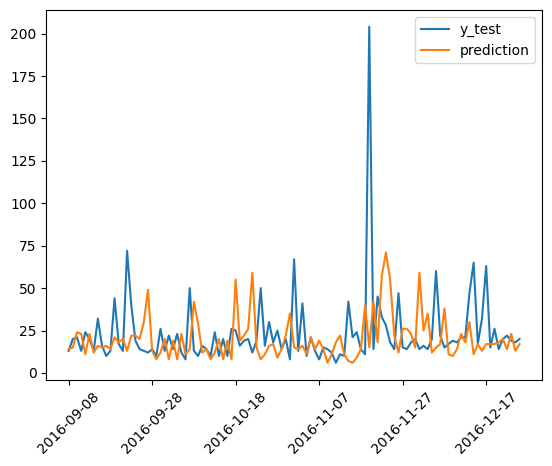

In [7]:
# plotting our test answers vs our prediction
fig, ax = plt.subplots()

plt.plot(y_test, label="y_test")
plt.plot(dt_reg_pred, label="prediction")
plt.legend()

ax.set_xticks(y_test.index[::20])
ax.set_xticklabels(y_test.index[::20], rotation=45)

## Metrics for error

So how did we do? While the plot does not look bad, we have no way of quantifying the accuracy of our predictions using the graph. Thus, we rely on a few different error metrics to glean our performance (note: $a$ is acutal value, $e$ is expected value):

- mean absolute error: $\frac{1}{n}\sum^{n}_{i = 1}|e_i-a_i|$: gives a balanced, easily interpretable value for measuring model performance.
- mean squared error: $\frac{1}{n}\sum^{n}_{i = 1}(e_i-a_i)^2$: gives a value that penalises higher error values more harshly, but is highly biased towards them (ie penalises them too harsly for some cases).
- root mean squared error: $\sqrt{\frac{1}{n}\sum^{n}_{i = 1}(e_i-a_i)^2}$: gives a value that penalises higher error values more harshly, but is less biased towards them than MSE.

In [8]:
def mean_absolute_error(x, y):
    return statistics.mean(list(map(lambda x, y: abs(y - x), x, y)))

def mean_squared_error(x, y):
    return statistics.mean(list(map(lambda x, y: (y - x) ** 2, x, y)))

def root_mean_squared_error(x, y):
    return math.sqrt(statistics.mean(list(map(lambda x, y: (y - x) ** 2, x, y))))

In [9]:
# error statistics for decision tree regression

print(mean_absolute_error(y_test, dt_reg_pred))
print(mean_squared_error(y_test, dt_reg_pred))
print(root_mean_squared_error(y_test, dt_reg_pred))

15.119266055045872
707.816513761468
26.604821250319798


## Model 2: SARIMA

SARIMA is a well known time series forecasting model, which hijacks several time series modeling techniques and uses them in tandem to get a well-founded prediction. SARIMA combines the following techniques:

- Seasonality (S): We extract a periodic trend from the data in order to preserve any periodic aspects of the data in our forecasting.
- Autoregression (AR): We use lagged values (similar to the Decision Tree Regression) for prediction.
- Integrated (aka Time series differencing) (I): Instead of predicting based on the raw valuues of the time series, we use and predict differences between values.
- Moving Average (MA): We try to minimize the average of past prediction errors instead of the prediction error itself.

The 2 main components used in SARIMA are an AR and an MA model. The I step is performed in preprocessing. To support S, we have a separate AR and MA model which operates on the seasonal component of the time series (figured out in preprocessing). 

As a result of combining several models like this we have many configurable hyperparameters, which you can see in the summary below:

- dataset: one single time series
- parameters: $p$ weights for the AR model, $q$ parameters for the MA model, $p_s$ weights for the seasonal AR model, $q_s$ parameters for the seasonal MA model
- hyperparameters: `order` = $(p, d, q)$, `seasonal_order` = $(p_s, d_s, q_s, period)$. `order` contains the parameters for the ARIMA portion of the model and `seasonal_order` contains the parameters for the seasonal portion.
    - $p$: degree of regression to use
    - $d$: we use $d$th differences for prediction
    - $q$: number of lags for moving average
    - $p_s$: degree of regression to use for seasonal component
    - $d_s$: we use $d$th differences for prediction for seasonal component
    - $q_s$: number of lags for moving average for seasonal component
    - $period$: period of the seasonal component
- fitting algorithm: multiple iterations to tune the parameters
- prediction function: run an unknown point through the tuned SARIMA formula to get a prediction
- input space: time series sequence of a specified length
- output space: real numbers

### Preprocessing

Luckily for us, none is required! The `statsmodels` library does everything we need for us. We simply create our train/test split.

In [10]:
# input
X = train_df.iloc[0]

# creating train/test split
def train_test_split_sarima(X, y, train_fraction=0.8):
    return X.iloc[:int(train_fraction*len(X))], \
            X.iloc[int(train_fraction*len(X)):], \
            y.iloc[:int(train_fraction*len(y))], \
            y.iloc[int(train_fraction*len(y)):]

X_train, X_test, _, _ = train_test_split_sarima(X, X)

# creating model
arma_model = SARIMAX(X_train, order = (2, 2, 2), seasonal_order=(2,2,2,12))

# fitting model
arma_model = arma_model.fit()

# creating predictions using model
y_pred = arma_model.get_forecast(len(X_test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05)
y_pred_df = arma_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33488D+00    |proj g|=  1.22436D-01


 This problem is unconstrained.



At iterate    5    f=  5.29246D+00    |proj g|=  8.51112D-03

At iterate   10    f=  5.25196D+00    |proj g|=  9.47899D-02

At iterate   15    f=  5.01046D+00    |proj g|=  6.39148D-02

At iterate   20    f=  4.97699D+00    |proj g|=  3.89184D-02

At iterate   25    f=  4.87705D+00    |proj g|=  4.70144D-02

At iterate   30    f=  4.87390D+00    |proj g|=  5.21688D-03

At iterate   35    f=  4.85719D+00    |proj g|=  4.91831D-02

At iterate   40    f=  4.85220D+00    |proj g|=  7.45735D-03

At iterate   45    f=  4.84609D+00    |proj g|=  2.11006D-02

At iterate   50    f=  4.84109D+00    |proj g|=  2.65354D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/abhijain/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[Text(0.0, 0, '2016-09-13'),
 Text(20.0, 0, '2016-10-03'),
 Text(40.0, 0, '2016-10-23'),
 Text(60.0, 0, '2016-11-12'),
 Text(80.0, 0, '2016-12-02'),
 Text(100.0, 0, '2016-12-22')]

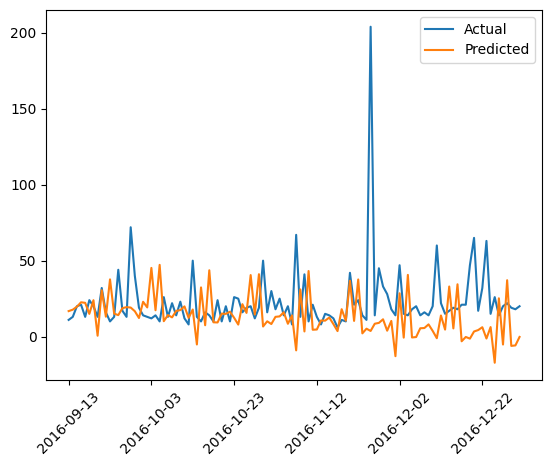

In [11]:
# plotting our test data vs our prediction
fig, ax = plt.subplots()

plt.plot(X_test, label="Actual")
plt.plot(y_pred_df.values, label="Predicted")
plt.legend()

ax.set_xticks(X_test.index[::20])
ax.set_xticklabels(X_test.index[::20], rotation=45)

In [12]:
print(mean_absolute_error(X_test, y_pred_df.values))
print(mean_squared_error(X_test, y_pred_df.values))
print(root_mean_squared_error(X_test, y_pred_df.values))

17.73237007256518
840.8107718969991
28.99673726295769


### Grid search: a better way to search for the best hyperparameters

We could just keep trying to search for the best hyperparamters manually, but that would take a lot of time. So instead, let's define some values we want to try and then have the computer try them for us and pick the best ones.

We can't actually have the algorithm pick hyperparameters out of thin air (that's way more advanced). In the meantime, grid search simply tests every set of hyperparamters we define and picks the one with the lowest error. In this case we want to use RMSE as our error metric since we want to penialise large errors harshly, but not too harshly.

In [ ]:
def sarima_train_predict(p, d, q, p_s, d_s, q_s, period):
    X_train, X_test, _, _ = train_test_split_sarima(X, X)

    # creating model
    arma_model = SARIMAX(X_train, order = (p, d, q), seasonal_order=(p_s, d_s, q_s, period))

    # fitting model
    arma_model = arma_model.fit()

    # creating predictions using model
    y_pred = arma_model.get_forecast(len(X_test.index))
    y_pred_df = y_pred.conf_int(alpha = 0.05)
    y_pred_df = arma_model.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])

    return root_mean_squared_error(X_test, y_pred_df.values)

lp = [1, 2]
ld = [0, 1, 2]
lq = [1, 2]
lp_s = [1, 2]
ld_s = [0, 1, 2]
lq_s = [1, 2]
lperiod = [7, 12, 30]

combinations = [(p, d, q, p_s, d_s, q_s, period) for p in lp for d in ld for q in lq for p_s in lp_s for d_s in ld_s for q_s in lq_s for period in lperiod]

results = dict()

for (p, d, q, p_s, d_s, q_s, period) in combinations:
    try:
        results[(p, d, q, p_s, d_s, q_s, period)] = sarima_train_predict(p, d, q, p_s, d_s, q_s, period)
    except:
        pass

print(max(results, key=results.get))


## Model 3: RNN

Both of the above models are quite useful on a single time series, but we have 145000 time series to take a look at! We need a model which is robust enough to support all the time series rather than just one. Enter the RNN.

The RNN (Recurrent Neural Network) is a neural network with built-in "memory"- it remembers values it sees and uses them as part of its decision process. The memory mechanism is known as LSTM (Long short-term memory)- a type of neural network layer which contains gates to control the influence of current and past values on its output.

Model summary:

- dataset:one or more time series
- parameters: Weights and biases of the neural network
- hyperparameters:
    - epochs: number of training iterations
    - batch size: number of samples after which to update weights
    - loss function: function for determining the error of the network
    - optimizer: function which enhances the weight-updating process
    There are many more hyperparamters, however this example only covers these 4.
- fitting algorithm: multiple iterations to update the weights and biases.
- prediction function: run an unknown point through the network to get a forecasted value.
- input space: time series sequence of a specified length
- output space: real numbers

NOTE: we provide 2 implementations here, one which operates on a single time series and one that operates on all of them.

### Preprocessing

The network relies on lags. This is because it attempts to recognize trends in previous values and determine how to use them in predictions. We construct our lags as follows:

To predict the value at $t_n$, we use the values $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$ for some value $k$ as our lags for prediction.

We will need to construct lags to enable training. Thus, for each point in the time series from the $k$th point onward, we construct a dataframe of $[t_{n-k}, t_{n-k+1}, ..., t_{n-1}]$. The lag values are stored in the columns $[X_1, X_2, ..., X_k]$. The output value is stored in column $y$.

We also need a second step of preprocessing: we need to scale the data down. This is because nerual networks do not like large values, they prefer values near 0. Thus, we use the `StandardScaler` to scale our data down. This scaler will de-mean the data and divide all points by the standard deviation across the dataset.

_Sidenote: is the architecture of the network a hyperparamter?_ The answer is no, as it the algorithm is configured based on its architecture. The architecture defines the fitting algorithm itself.

### Implementation 1: Single time series

In [27]:
# creates lags and the train/test split in 1 go
def create_train_test_nn(row, n_steps=6):
    ret_df = pd.DataFrame(columns=([f"X_{i}" for i in range(1, n_steps + 1)] + ["y"]))
    for i in range(0, n_steps):
        ret_df[f"X_{i + 1}"] = row.shift(-i)
    ret_df["y"] = row.shift(-n_steps)
    ret_df = ret_df.reset_index().dropna()
    return ret_df.iloc[:int(0.8*len(ret_df))], ret_df.iloc[int(0.8*len(ret_df)):]

# setting up scaler for values
train_nn_scaler = StandardScaler()

# scaling values
train_nn_df = pd.DataFrame(train_nn_scaler.fit_transform(train_df.iloc[0].values.reshape(-1, 1)))

# creating dataframes
train_nn_formatted, test_nn_formatted = create_train_test_nn(train_nn_df, n_steps=25)

# # note: we are limiting to 2000 time series since i don't want my computer to explode
# for i in range(1, 2000):
#     if not i % 100: print(i)
#     train_nn_formatted_addition, test_nn_formatted_addition = create_train_test_nn(train_nn_df.iloc[i], n_steps=25)
#     train_nn_formatted = pd.concat([train_nn_formatted, train_nn_formatted_addition], ignore_index=True)
#     test_nn_formatted = pd.concat([test_nn_formatted, test_nn_formatted_addition], ignore_index=True)

In [28]:
# reshaping time series so the model can use it
X_train = np.array(train_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
y_train = train_nn_formatted["y"].values
X_test = np.array(test_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
y_test = test_nn_formatted["y"].values

In [57]:
# creating model
model = Sequential([
    Input(shape=(1, 25)),
    LSTM(units=25, input_shape=(1, 25), return_sequences=True, activation=tf.nn.relu),
    LSTM(units=10, input_shape=(25, ), activation=tf.nn.relu),
    Dense(1)
])

# setting up model
model.compile(optimizer="adam", loss="mean_squared_error")

# fitting model
model.fit(X_train, y_train, epochs=200, batch_size=20)

# making predictions
model_results = model.predict(X_test)

Epoch 1/200
21/21 [==============================] - 1s 1ms/step - loss: 1.1537
Epoch 2/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1496
Epoch 3/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1463
Epoch 4/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1408
Epoch 5/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1316
Epoch 6/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1198
Epoch 7/200
21/21 [==============================] - 0s 1ms/step - loss: 1.1044
Epoch 8/200
21/21 [==============================] - 0s 1ms/step - loss: 1.0810
Epoch 9/200
21/21 [==============================] - 0s 1ms/step - loss: 1.0519
Epoch 10/200
21/21 [==============================] - 0s 1ms/step - loss: 1.0341
Epoch 11/200
21/21 [==============================] - 0s 1ms/step - loss: 1.0125
Epoch 12/200
21/21 [==============================] - 0s 1ms/step - loss: 0.9990
Epoch 13/200
21/21 [=================

21/21 [==============================] - 0s 1ms/step - loss: 0.3634
Epoch 103/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3546
Epoch 104/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3455
Epoch 105/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3370
Epoch 106/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3338
Epoch 107/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3239
Epoch 108/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3186
Epoch 109/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3151
Epoch 110/200
21/21 [==============================] - 0s 1ms/step - loss: 0.3033
Epoch 111/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2939
Epoch 112/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2879
Epoch 113/200
21/21 [==============================] - 0s 1ms/step - loss: 0.2954
Epoch 114/200
21/21 [=========

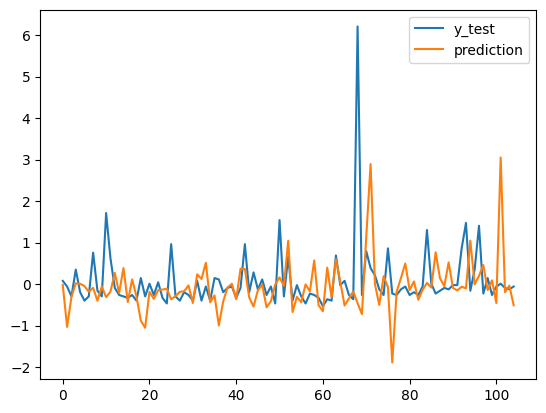

In [58]:
# plotting predictions
fig, ax = plt.subplots()

plt.plot(y_test, label="y_test")
plt.plot(model_results, label="prediction")
plt.legend()

4/4 [==============================] - 0s 1ms/step
[-0.12792399371545787, -0.3663109132723372, -0.5706425586068051, -0.29820036482751455, -0.2641450906051032, -0.43442146171715984, -0.43442146171715984, 0.008297103174187442, 0.14451820006383276, 0.0764076516190101, -0.09386871949304655, -0.4003661874947485, -0.2641450906051032, -0.23008981638269188, -0.4684767359395712, -0.19603454216028054, -0.4684767359395712, -0.4684767359395712, -0.19603454216028054, -0.5025320101619826, -0.3663109132723372, -0.4003661874947485, -0.059813445270635215, -0.12792399371545787, -0.23008981638269188, 0.13775689899921417, 1.1037927865982056, -0.4819808900356293, -0.12273773550987244, -0.04458355903625488, -0.4827837646007538, -0.37191906571388245, -0.16379454731941223, -0.42913392186164856, 0.1537897139787674, -0.40465232729911804, -0.5374851226806641, -0.8109837770462036, -0.39322730898857117, -0.23066478967666626, -0.51970374584198, -0.22486278414726257, -0.5700194835662842, -0.5593523979187012, -0.4141

[Text(0.0, 0, '2015-07-01'),
 Text(20.0, 0, '2015-07-21'),
 Text(40.0, 0, '2015-08-10'),
 Text(60.0, 0, '2015-08-30'),
 Text(80.0, 0, '2015-09-19'),
 Text(100.0, 0, '2015-10-09'),
 Text(120.0, 0, '2015-10-29'),
 Text(140.0, 0, '2015-11-18'),
 Text(160.0, 0, '2015-12-08'),
 Text(180.0, 0, '2015-12-28'),
 Text(200.0, 0, '2016-01-17'),
 Text(220.0, 0, '2016-02-06'),
 Text(240.0, 0, '2016-02-26'),
 Text(260.0, 0, '2016-03-17'),
 Text(280.0, 0, '2016-04-06'),
 Text(300.0, 0, '2016-04-26'),
 Text(320.0, 0, '2016-05-16'),
 Text(340.0, 0, '2016-06-05'),
 Text(360.0, 0, '2016-06-25'),
 Text(380.0, 0, '2016-07-15'),
 Text(400.0, 0, '2016-08-04'),
 Text(420.0, 0, '2016-08-24'),
 Text(440.0, 0, '2016-09-13'),
 Text(460.0, 0, '2016-10-03'),
 Text(480.0, 0, '2016-10-23'),
 Text(500.0, 0, '2016-11-12'),
 Text(520.0, 0, '2016-12-02'),
 Text(540.0, 0, '2016-12-22')]

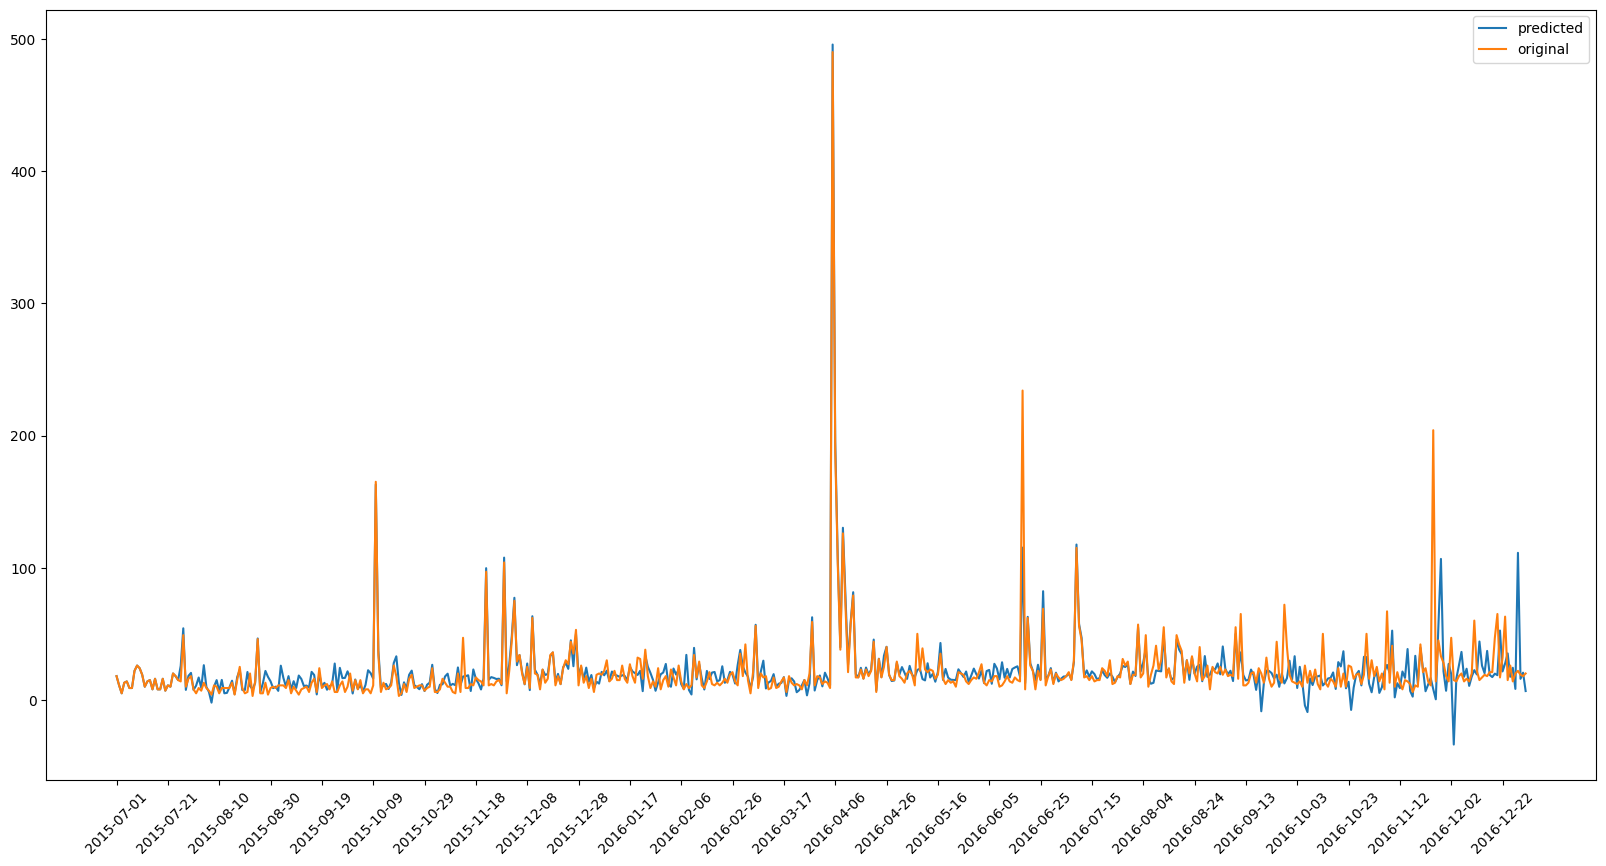

In [63]:
# forecasting a specific time series

test_series = 0

in_series = train_nn_df.copy(deep=True)

X_1, X_2 = create_train_test_nn(in_series, n_steps=25)

del X_1["index"]
del X_1["y"]

del X_2["index"]
del X_2["y"]

r1 = model.predict(X_1.values.reshape(-1, 1, 25))
r2 = model.predict(X_2.values.reshape(-1, 1, 25))

out = in_series.values.reshape(-1)[:25].tolist() + r1.reshape(-1).tolist() + r2.reshape(-1).tolist()

#train_nn_df_copy = train_nn_df.copy(deep=True)

#train_nn_df_copy.iloc[test_series] = pd.Series(out)

#series = train_nn_scaler.inverse_transform(train_nn_df_copy)[test_series]

series = train_nn_scaler.inverse_transform(np.array(out).reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(series, label="predicted")
plt.plot(train_df.iloc[test_series], label="original")
plt.legend()

ax.set_xticks(train_df.iloc[test_series].index[::20])
ax.set_xticklabels(train_df.iloc[test_series].index[::20], rotation=45)

In [66]:
# error on the sample time series
print(mean_absolute_error(series.reshape(-1), train_df.iloc[0]))
print(mean_squared_error(series.reshape(-1), train_df.iloc[0]))
print(root_mean_squared_error(series.reshape(-1), train_df.iloc[0]))

6.593995687137155
206.04479315061707
14.35426045293233


### Implementation 2: all time series

In [3]:
# creates lags and the train/test split in 1 go
def create_train_test_nn(row, index_name, n_steps=6):
    ret_df = pd.DataFrame(columns=([f"X_{i}" for i in range(1, n_steps + 1)] + ["y"]))
    for i in range(0, n_steps):
        ret_df[f"X_{i + 1}"] = row.shift(-i)
    ret_df["y"] = row.shift(-n_steps)
    ret_df = ret_df.reset_index().dropna()
    ret_df["name"] = [index_name for i in range(len(ret_df))]
    return ret_df.iloc[:int(0.8*len(ret_df))], ret_df.iloc[int(0.8*len(ret_df)):]

train_df_temp = train_df.iloc[:2000]

scalers = [StandardScaler() for i in range(2000)]

train_nn_df = train_df_temp.copy(deep=True)

# scaling values
for i in range(2000):
    train_nn_df.iloc[i] = scalers[i].fit_transform(train_nn_df.iloc[i].values.reshape(-1, 1)).reshape(-1)

# creating dataframes
train_nn_formatted, test_nn_formatted = create_train_test_nn(train_nn_df.iloc[0], train_df.iloc[0].name, n_steps=25)

# note: we are limiting to 2000 time series since i don't want my computer to explode
for i in range(1, 2000):
    if not i % 100: print(i)
    train_nn_formatted_addition, test_nn_formatted_addition = create_train_test_nn(train_nn_df.iloc[i], train_df.iloc[i].name, n_steps=25)
    train_nn_formatted = pd.concat([train_nn_formatted, train_nn_formatted_addition], ignore_index=True)
    test_nn_formatted = pd.concat([test_nn_formatted, test_nn_formatted_addition], ignore_index=True)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [4]:
X_train = np.array(train_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
C_train = np.array(train_nn_formatted["name"].values).reshape(-1, 1)
y_train = train_nn_formatted["y"].values
X_test = np.array(test_nn_formatted[[f"X_{i}" for i in range(1, 26)]].values).reshape(-1, 1, 25)
C_test = np.array(test_nn_formatted["name"].values).reshape(-1, 1)
y_test = test_nn_formatted["y"].values

from keras.layers import StringLookup
from pprint import pprint

vocab = list(set([i for j in map(lambda x: x.split("_"), np.concatenate((C_train, C_test)).reshape(-1)) for i in j]))

embedding_creator = StringLookup(vocabulary=vocab, output_mode="int")

embedding_dict = dict()

for item in set(np.concatenate((C_train, C_test)).reshape(-1).tolist()):
    if not embedding_dict.get(item):
        tensor = tf.cast(embedding_creator(tf.constant(item.split("_"))), dtype=tf.float32)
        tensor = tf.divide(
           tf.subtract(
              tensor, 
              tf.reduce_min(tensor)
           ), 
           tf.subtract(
              tf.reduce_max(tensor), 
              tf.reduce_min(tensor)
           )
        )
        embedding_dict[item] = tensor


max_len = embedding_dict[max(embedding_dict, key=lambda x: len(embedding_dict[x]))]

for k, embedding in embedding_dict.items():
    embedding_dict[k] = tf.pad(embedding, [[1, max_len.shape[0] - embedding.shape[0]]], "CONSTANT", constant_values=0)  

C_train = np.array(list(map(lambda x: embedding_dict[x], C_train.reshape(-1)))).reshape(-1, 11)
C_test = np.array(list(map(lambda x: embedding_dict[x], C_test.reshape(-1)))).reshape(-1, 11)

In [5]:
from keras.layers import Wrapper
from keras import backend as Backend
from tensorflow.python.keras.utils import generic_utils

class HiddenStateInitialization(Wrapper):
    def __init__(self, layer, **kwargs):
        super(HiddenStateInitialization, self).__init__(layer, **kwargs)
        
    def build(self, input_shape=None):
        self.dense_layer = Dense(units=self.layer.units)
    
    @property
    def go_backwards(self):
        return self.layer.go_backwards

    @property
    def return_sequences(self):
        return self.layer.return_sequences

    @property
    def return_state(self):
        return self.layer.return_state
    
    def call(self, inputs, training=None, **kwargs):
        layer_input = inputs[0]
        initializer = Backend.expand_dims(inputs[1], axis=0)
        if generic_utils.has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        state = tf.unstack(self.dense_layer(initializer))
        return self.layer(layer_input, initial_state=state, **kwargs)

# creating model
model2 = Sequential([
    HiddenStateInitialization(GRU(units=25, return_sequences=True, activation=tf.nn.relu)),
    GRU(units=10, input_shape=(25, ), activation=tf.nn.relu),
    Dense(1)
])

# setting up model
model2.compile(optimizer="adam", loss="mean_squared_error")

# fitting model
model2.fit([X_train, C_train], y_train, epochs=10, batch_size=420, shuffle=True)

# making predictions
model_results2 = model2.predict([X_test, C_test])

Epoch 1/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8054
Epoch 2/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7987
Epoch 3/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7975
Epoch 4/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7968
Epoch 5/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7960
Epoch 6/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7954
Epoch 7/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7949
Epoch 8/10
2000/2000 [==============================] - 3s 2ms/step - loss: 0.7942
Epoch 9/10
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7935
Epoch 10/10
6563/6563 [==============================] - 4s 639us/step


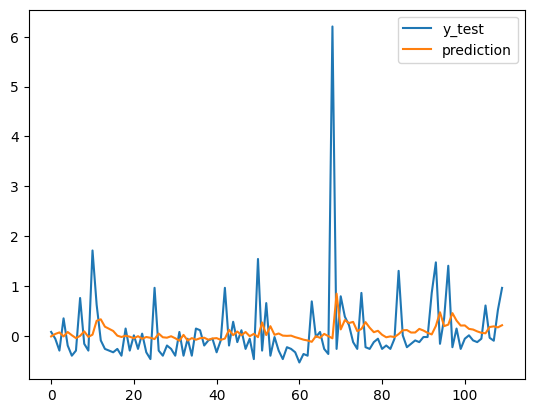

In [6]:
fig, ax = plt.subplots()

plt.plot(y_test[:110], label="y_test")
plt.plot(model_results2[:110], label="prediction")
plt.legend()

420 105
4/4 [==============================] - 0s 940us/step


[Text(0.0, 0, '2015-07-01'),
 Text(20.0, 0, '2015-07-21'),
 Text(40.0, 0, '2015-08-10'),
 Text(60.0, 0, '2015-08-30'),
 Text(80.0, 0, '2015-09-19'),
 Text(100.0, 0, '2015-10-09'),
 Text(120.0, 0, '2015-10-29'),
 Text(140.0, 0, '2015-11-18'),
 Text(160.0, 0, '2015-12-08'),
 Text(180.0, 0, '2015-12-28'),
 Text(200.0, 0, '2016-01-17'),
 Text(220.0, 0, '2016-02-06'),
 Text(240.0, 0, '2016-02-26'),
 Text(260.0, 0, '2016-03-17'),
 Text(280.0, 0, '2016-04-06'),
 Text(300.0, 0, '2016-04-26'),
 Text(320.0, 0, '2016-05-16'),
 Text(340.0, 0, '2016-06-05'),
 Text(360.0, 0, '2016-06-25'),
 Text(380.0, 0, '2016-07-15'),
 Text(400.0, 0, '2016-08-04'),
 Text(420.0, 0, '2016-08-24'),
 Text(440.0, 0, '2016-09-13'),
 Text(460.0, 0, '2016-10-03'),
 Text(480.0, 0, '2016-10-23'),
 Text(500.0, 0, '2016-11-12'),
 Text(520.0, 0, '2016-12-02'),
 Text(540.0, 0, '2016-12-22')]

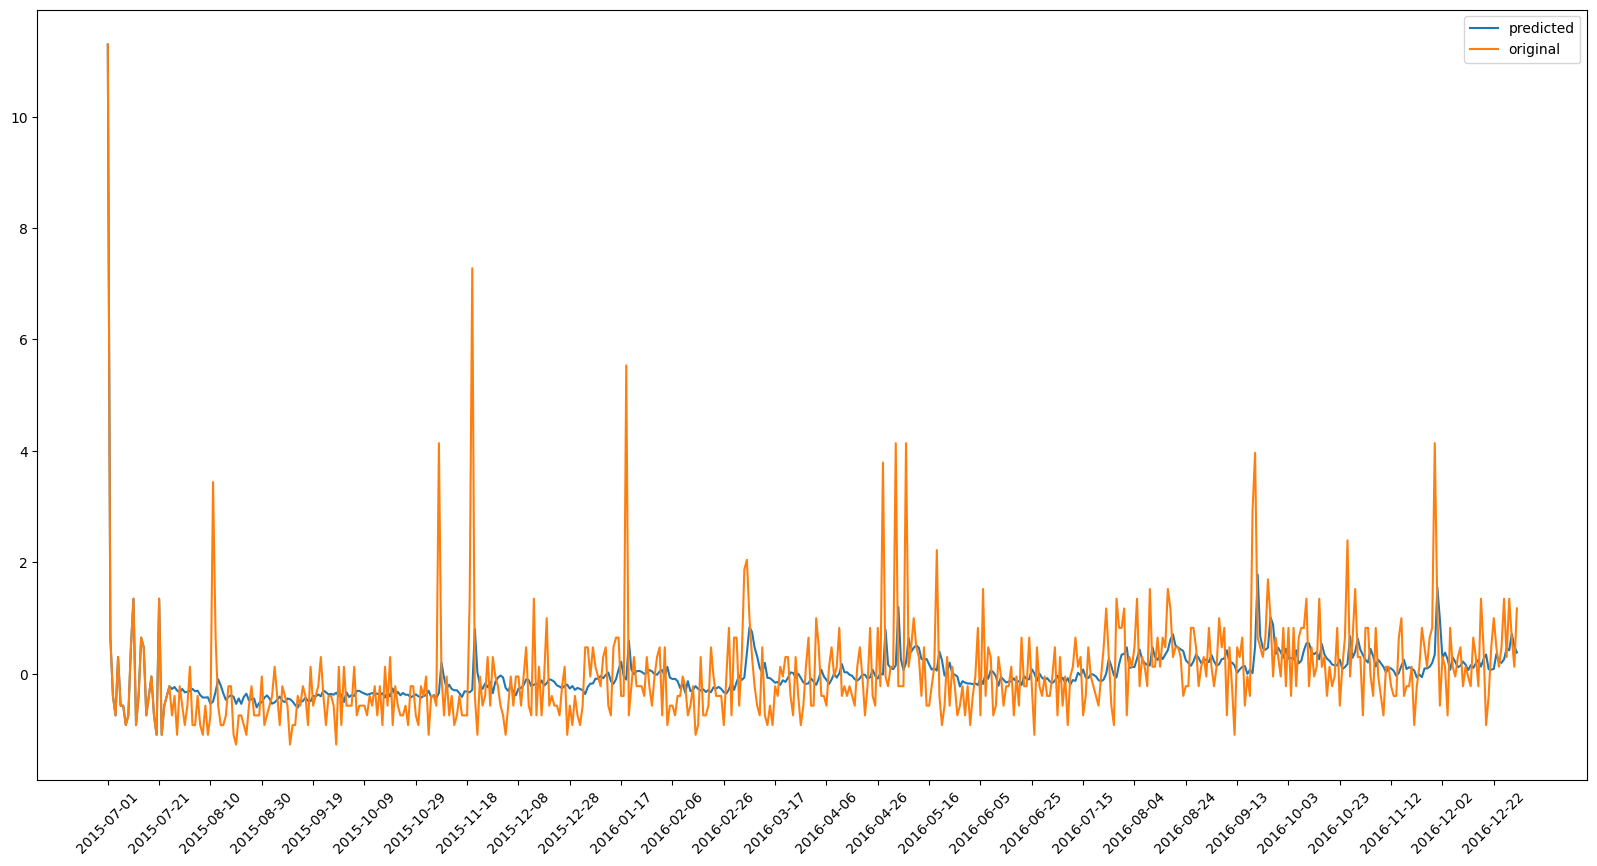

In [12]:
test_series = 1975

in_series = train_nn_df.copy(deep=True).iloc[test_series]

X_1, X_2 = create_train_test_nn(in_series, train_df.iloc[test_series].name, n_steps=25)

print(len(X_1), len(X_2))

index_1 = np.array([embedding_dict[z] for z in X_1["name"].values])
index_2 = np.array([embedding_dict[z] for z in X_2["name"].values])

del X_1["index"]
del X_1["y"]
del X_1["name"]

del X_2["index"]
del X_2["y"]
del X_2["name"]

r1 = model2.predict([X_1.values.reshape(-1, 1, 25), index_1])
r2 = model2.predict([X_2.values.reshape(-1, 1, 25), index_2])

out = in_series.values.reshape(-1)[:25].tolist() + r1.reshape(-1).tolist() + r2.reshape(-1).tolist()

predicted_plot = scalers[test_series].inverse_transform(np.array(out).reshape(-1, 1))
original_plot = scalers[test_series].inverse_transform(in_series.values.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(out, label="predicted")
plt.plot(in_series, label="original")
plt.legend()

ax.set_xticks(train_df.iloc[0].index[::20])
ax.set_xticklabels(train_df.iloc[0].index[::20], rotation=45)

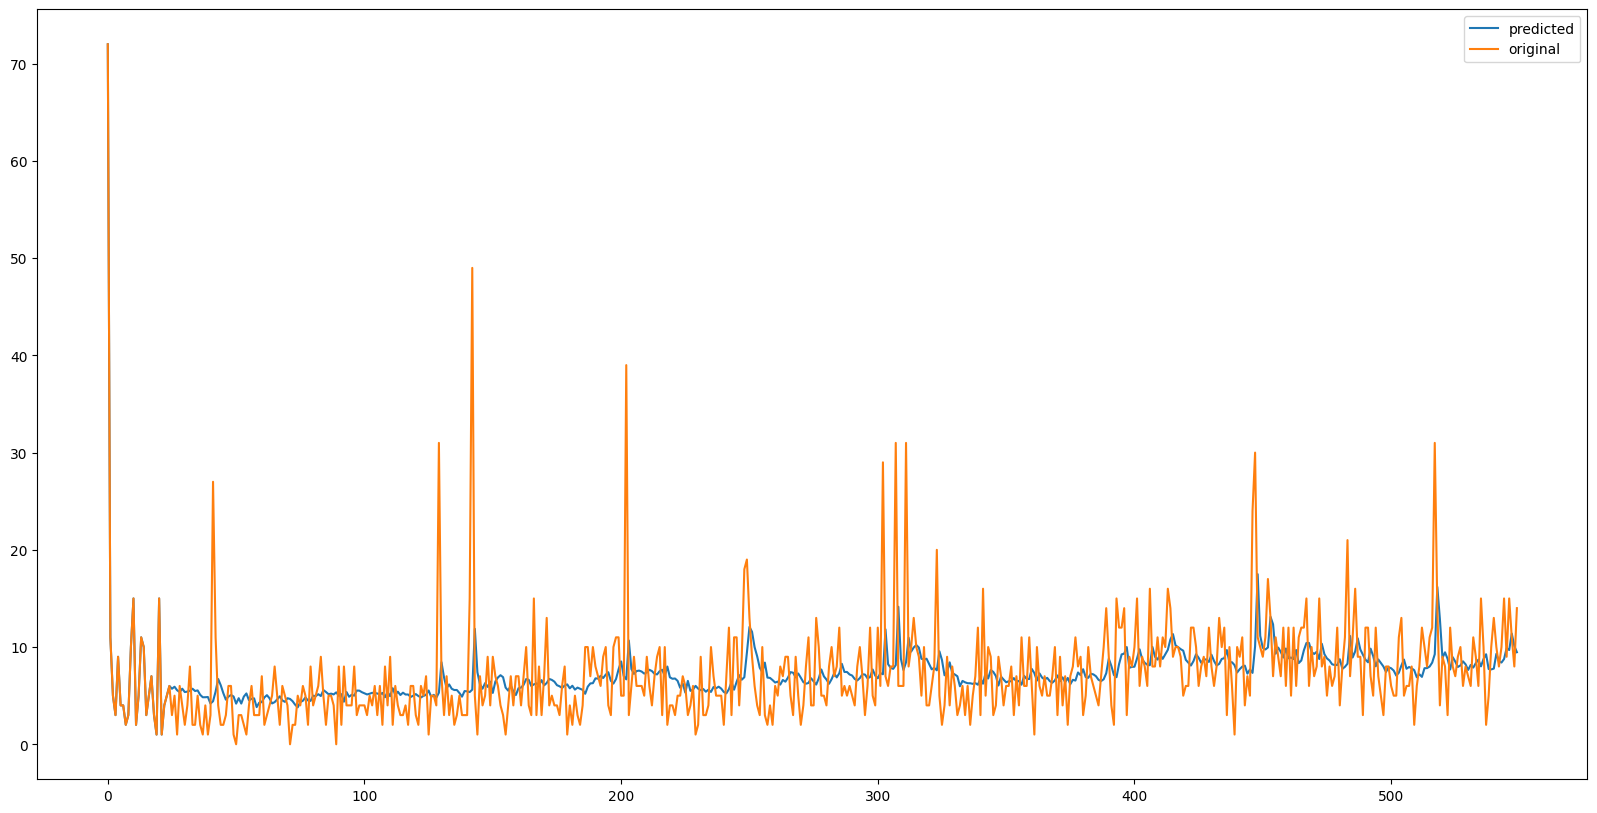

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))

plt.plot(predicted_plot, label="predicted")
plt.plot(original_plot, label="original")
plt.legend()

## What's next?

This notebook should have left you with more questions than answers. The best way to get familiar with machine learning models is to practice! Pick a project and read up on how someone else solved it. Then, without borrowing their code, try and replicate it yourself. Try changing the model they use and see if you can get better results. Use trial and error (or a better method) to tune the model for maximum results. Doing this over and over will help solidify your intuition on machine learning without having to know all the underlying math (though that helps quite a bit)!